In [40]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor

from task3_1 import preprocess_star_dataset, preprocess_gwp_dataset
from task3_2 import evaluate_classification_model, evaluate_regression_model

## Star Dataset

First, let's use the `preprocess_star_dataset` function created in task 3.1 to load and preprocess the star dataset

In [2]:
star_X, star_Y = preprocess_star_dataset('datasets/star_assessment.csv')

#### Train an SVM classifier using the holdout method

The type of model that will be used for the star dataset is a Support Vector Machine, which are a type of supervised learning model that can be used for classification and regression tasks. In this case, an SVM classifier will be used to classify the star dataset into the three classes of stars, galaxies and quasars. As it is a supervised learning model, first let's split the dataset into training and testing sets.

In [3]:
star_x_train, star_x_test, star_y_train, star_y_test = train_test_split(star_X, star_Y, test_size=0.2, stratify=star_Y)

Then we can create and train a SVM classifier using the training set, then evaluate it by using the testing set to generate metrics such as accuracy and F1-score, and a confusion matrix.

Accuracy: 0.9663610348653857
Precision: 0.9660838827516897
Recall: 0.9663610348653857
F1-score: 0.9658502182475391


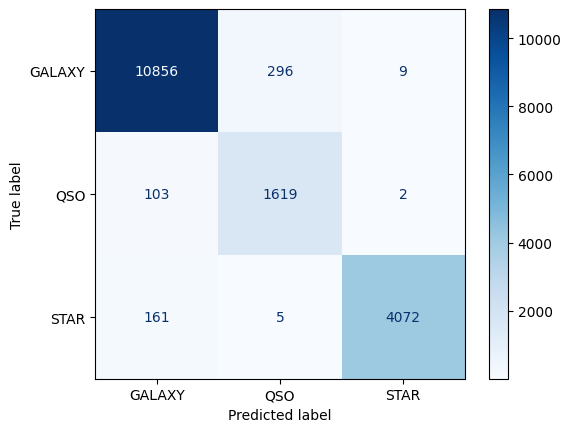

In [4]:
svc_holdout = SVC()
svc_holdout.fit(star_x_train, star_y_train)
evaluate_classification_model(svc_holdout, star_x_test, star_y_test)

The accuracy score calculated shows that the model is performing well, as it predicts the correct label for 96.6% of the samples in the test set. Additionally, since the precision and recall are balanced, this shows that the model doesn't predict to many false positives or false negatives. The confusion matrix shows that model struggles to classify quasars more than stars or galaxies, as approximately 6.1% of quasars were incorrectly predicted compared to 2.7% of galaxies and 3.9% of stars.

#### Evaluate an SVM classifier using cross-validation

Next, we can create an SVM classifier and evaluate it using cross-validation to get a better estimate of the model's performance, and calculate the mean accuracy and standard deviation of the model's performance across the folds.

In [16]:
svc_cv = SVC()
svc_cv_scores = cross_val_score(svc_cv, star_X, star_Y, scoring='accuracy', n_jobs=-1)
print(f'Mean accuracy: {svc_cv_scores.mean()}')
print(f'Standard deviation: {svc_cv_scores.std()}')

Mean accuracy: 0.9644096152996191
Standard deviation: 0.0008522282547938581


The high mean accuracy and low standard deviation of the model's performance across the folds shows that the model is performing well. However, there is still room for improvement with an SVM classifier, thus the next step is to perform hyperparameter tuning to improve the model's performance.

#### Perform SVM classifier hyperparameter tuning

To tune the hyperparameters of a machine learning model, a common approach is to use the grid search method. This involves creating a grid of possible values for each hyperparameter, then training and evaluating a model for each combination of hyperparameters. The best performing model is then selected, and the hyperparameters used to create it are returned. In this task, SciKit-Learn's `GridSearchCV` class will be used to perform grid search as it is a simple and effective way to perform hyperparameter tuning while also performing cross-validation.

Due to large dataset sizes resulting in longer training times, hyperparameter tuning will be performed in stages for the star dataset, starting with the `kernel` parameter. This is opposed to performing a full grid search over all hyperparameters at once (which will be performed on the GWP dataset later).

In [9]:
def tune_parameters(model, param_grid, X, Y, scoring='accuracy'):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring=scoring, n_jobs=-1, verbose=1)
    grid_search.fit(X, Y)

    print(f'Best Parameters:')
    for k, v in grid_search.best_params_.items():
        print(f'{k} = {v}')

    return grid_search.best_params_

In [8]:
svc_kernels = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

_ = tune_parameters(SVC(), svc_kernels, star_X, star_Y)

Best Parameters:
kernel = rbf


From the results, it is clear that a model with an `rbf` kernel is the best performing. Let's now tune the `C` and `gamma` parameters for this kernel.

In [10]:
svc_rbf_grid = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [0.1, 0.01, 0.001, 0.0001],
}

best_svc_params = tune_parameters(SVC(kernel='rbf'), svc_rbf_grid, star_X, star_Y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters:
C = 1000
gamma = 0.1


With these parameters, we can now train another SVM classifier and evaluate it using cross-validation, so that an effective comparison can be made with the previous model.

In [11]:
svc_tuned = SVC(**best_svc_params)
svc_tuned_scores = cross_val_score(svc_tuned, star_X, star_Y, scoring='accuracy', cv=10, n_jobs=-1)
print(f'Mean accuracy: {svc_tuned_scores.mean()}')
print(f'Standard deviation: {svc_tuned_scores.std()}')

Mean accuracy: 0.9725392085013876
Standard deviation: 0.001162952279931272


This model shows a solid improvement in accuracy over the previous model, given how high the accuracy of the previous model was. The mean accuracy of this model is 0.973 with a standard deviation of 0.001, which is fairly impressive for an SVM classifier.

Accuracy: 0.9724931378847165
Precision: 0.9721448686511166
Recall: 0.9724931378847165
F1-score: 0.9721938371521196


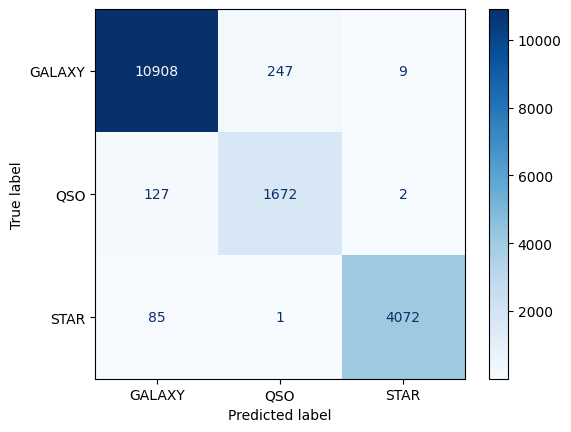

In [12]:
svc_tuned.fit(star_x_train, star_y_train)
evaluate_classification_model(svc_tuned, star_x_test, star_y_test)

When comparing this confusion matrix to the one produced by the initial SVM classifier, it is clear that the model has improved by the fact that the number of correctly predicted labels has increased. Interestingly, the number of samples incorrectly predicted as stars has remained the same, potentially indicating that some outliers still exist that the model struggles to classify. Additionally, the tuned model has incorrectly predicted more quasars as galaxies than the intial model.

## GWP Dataset

Similar to the star dataset, let's use a function created in task 3.1 to preprocess the GWP dataset.

In [41]:
gwp_X, gwp_Y = preprocess_gwp_dataset('datasets/gwp_assessment.csv')

#### Train a Random Forest Regressor using the holdout method

The model that will be used for the GWP dataset is 

First let's split the dataset into training and test sets

In [4]:
gwp_x_train, gwp_x_test, gwp_y_train, gwp_y_test = train_test_split(gwp_X, gwp_Y, test_size=0.2)

Then we can train a Random Forest Regressor using the training set and evaluate it using the test set

R^2 Score: 0.2194596854003137
Mean Absolute Error: 0.08185391097715311
Root Mean Squared Error: 0.13340712717205105


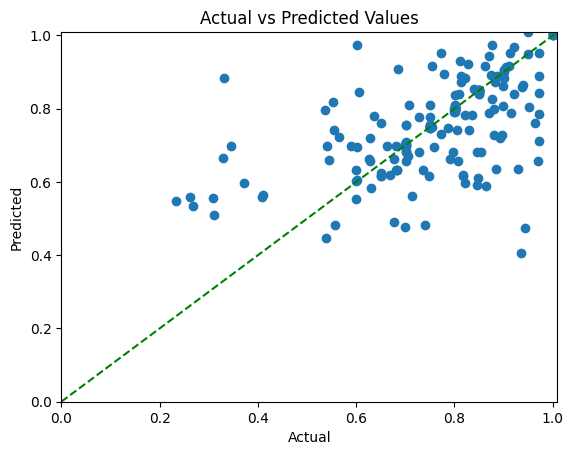

In [7]:
rf_holdout = RandomForestRegressor()
rf_holdout.fit(gwp_x_train, gwp_y_train)
evaluate_regression_model(rf_holdout, gwp_x_test, gwp_y_test)

#### Train a Random Forest Regressor using cross-validation

Next, we can train a Random Forest Regressor using cross-validation to get a better estimate of the model's performance, and calculate the mean R^2 score and standard deviation of the model's performance across the folds

In [8]:
rf_cv = RandomForestRegressor()
rf_cv_scores = cross_val_score(rf_cv, gwp_X, gwp_Y, scoring='r2', n_jobs=-1, cv=10)
print(f'Mean R^2 score: {rf_cv_scores.mean()}')
print(f'Standard deviation: {rf_cv_scores.std()}')

Mean R^2 score: 0.23486982133282286
Standard deviation: 0.11480174904658474


#### Perform Random Forest Regression hyperparameter tuning

As this dataset is much smaller than the star dataset, we can perform a full grid search over all hyperparameters at once. For a Random Forest Regressor, the hyperparameters are:
- `n_estimators`: The number of trees in the forest
- `max_depth`: The maximum depth of the tree
- `min_samples_split`: The minimum number of samples required to split an internal node
- `min_samples_leaf`: The minimum number of samples required to be at a leaf node
- `bootstrap`: Whether bootstrap samples are used when building trees

The hyperparameters used in the grid search are selected based upon knowledge gained from reading the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for the `RandomForestRegressor` class.

In [42]:
rf_param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

best_rf_params = tune_parameters(RandomForestRegressor(), rf_param_grid, gwp_X, gwp_Y, scoring='r2')

R^2 Score: 0.26331494355384066
Mean Absolute Error: 0.08038644654786174
Root Mean Squared Error: 0.12960516003369268


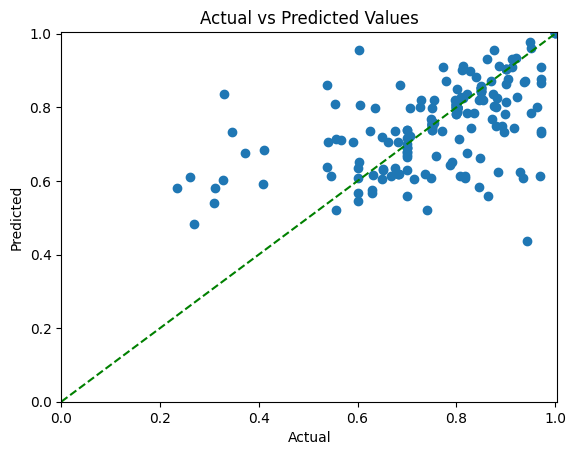

In [11]:
rf_tuned = RandomForestRegressor(**best_rf_params)
rf_tuned.fit(gwp_x_train, gwp_y_train)
evaluate_regression_model(rf_tuned, gwp_x_test, gwp_y_test)

## Markdown Question

*Is Linear Regression a good model to use for the star dataset? Justify your answer.*

Linear regression models assume a linear relationship between the features and the target variable, which isn't true in the case of many classification problems. In the star dataset, the target variable is categorical, namely having the classes `galaxy`, `qso` and `star`, meaning it is suited to be a classification task. Therefore, linear regression isn't a suitable model to use for this dataset, as there may not be a linear relationship between the features and the target. Additionally, using a linear regression model for the star dataset may result in predictions being made that don't fall into any of the three categories, making the predictions harder to interpret (and in certain cases, meaningless). Another reason why they shouldn't be used is that evaluation metrics commonly used for regression models, such as RMSE, are not suitable to be used for classification tasks, which use other metrics, including accuracy and F1-score. Finally, linear regression models are more sensitive to outliers than those suited to classification, which may result in the model being less accurate than a classification model.